## Решающие деревья

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплиментацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Решение должно содержать:
* Ноутбук homework-practice-05-Username.ipynb
* Модуль hw5code.py

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже:

__Оценка:__

In [164]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [165]:
from collections import Counter
from sklearn.base import BaseEstimator

In [166]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [167]:
from hw5code import find_best_split, DecisionTree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.preprocessing import OneHotEncoder

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [48]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0)
]

In [49]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

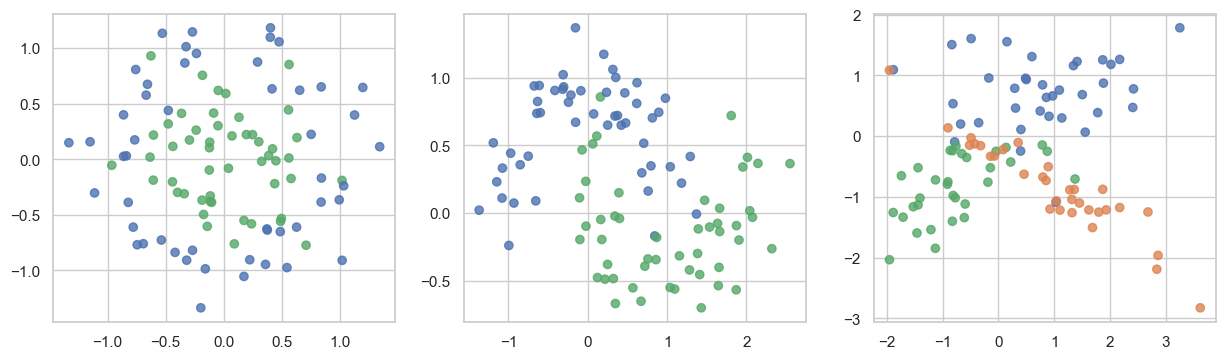

In [50]:
plt.figure(figsize = (15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [51]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors = np.array(palette)[y], linewidths=2)

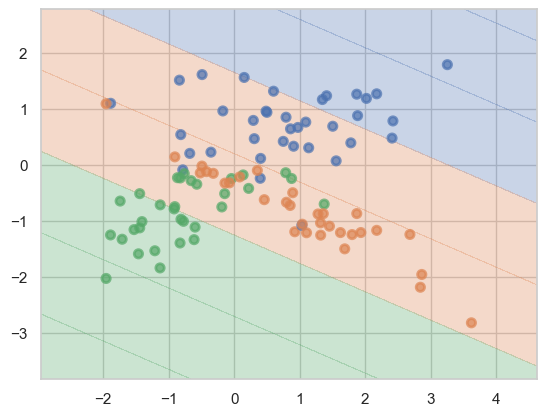

In [52]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

0  dataset: train accuracy:  1.0 , test accuracy:  0.76
1  dataset: train accuracy:  1.0 , test accuracy:  0.92
2  dataset: train accuracy:  1.0 , test accuracy:  0.72


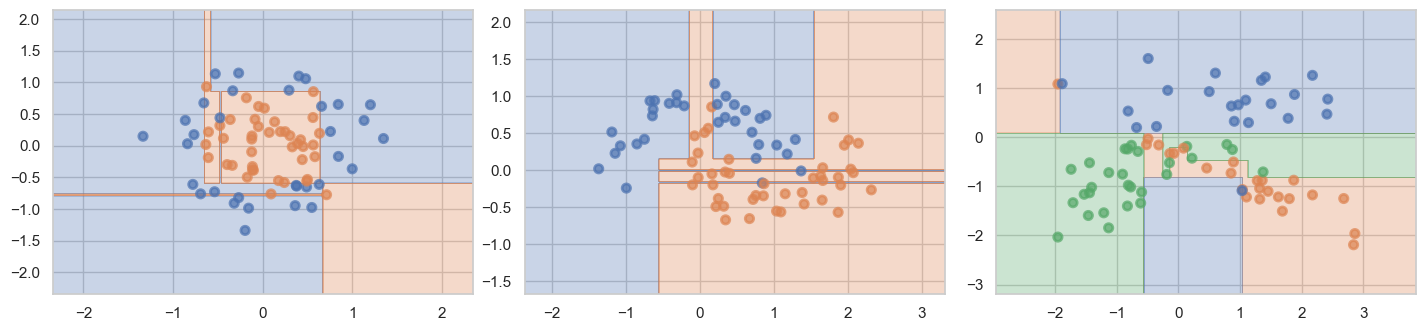

In [53]:
plt.figure(figsize = (15, 4))

for i, (x, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.75, random_state=42)
    tree = DecisionTreeClassifier()
    tree = tree.fit(X_train, y_train)
    
    plt.subplot(1, 3, i + 1)
    plot_surface(tree, X_train, y_train)
    
    print(i, ' dataset: train accuracy: ', tree.score(X_train, y_train), ', test accuracy: ', tree.score(X_test, y_test))

__Ответ:__ На тренировочной выборке результат стопроцентный, что может говорить о переобучении деревьев

__2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

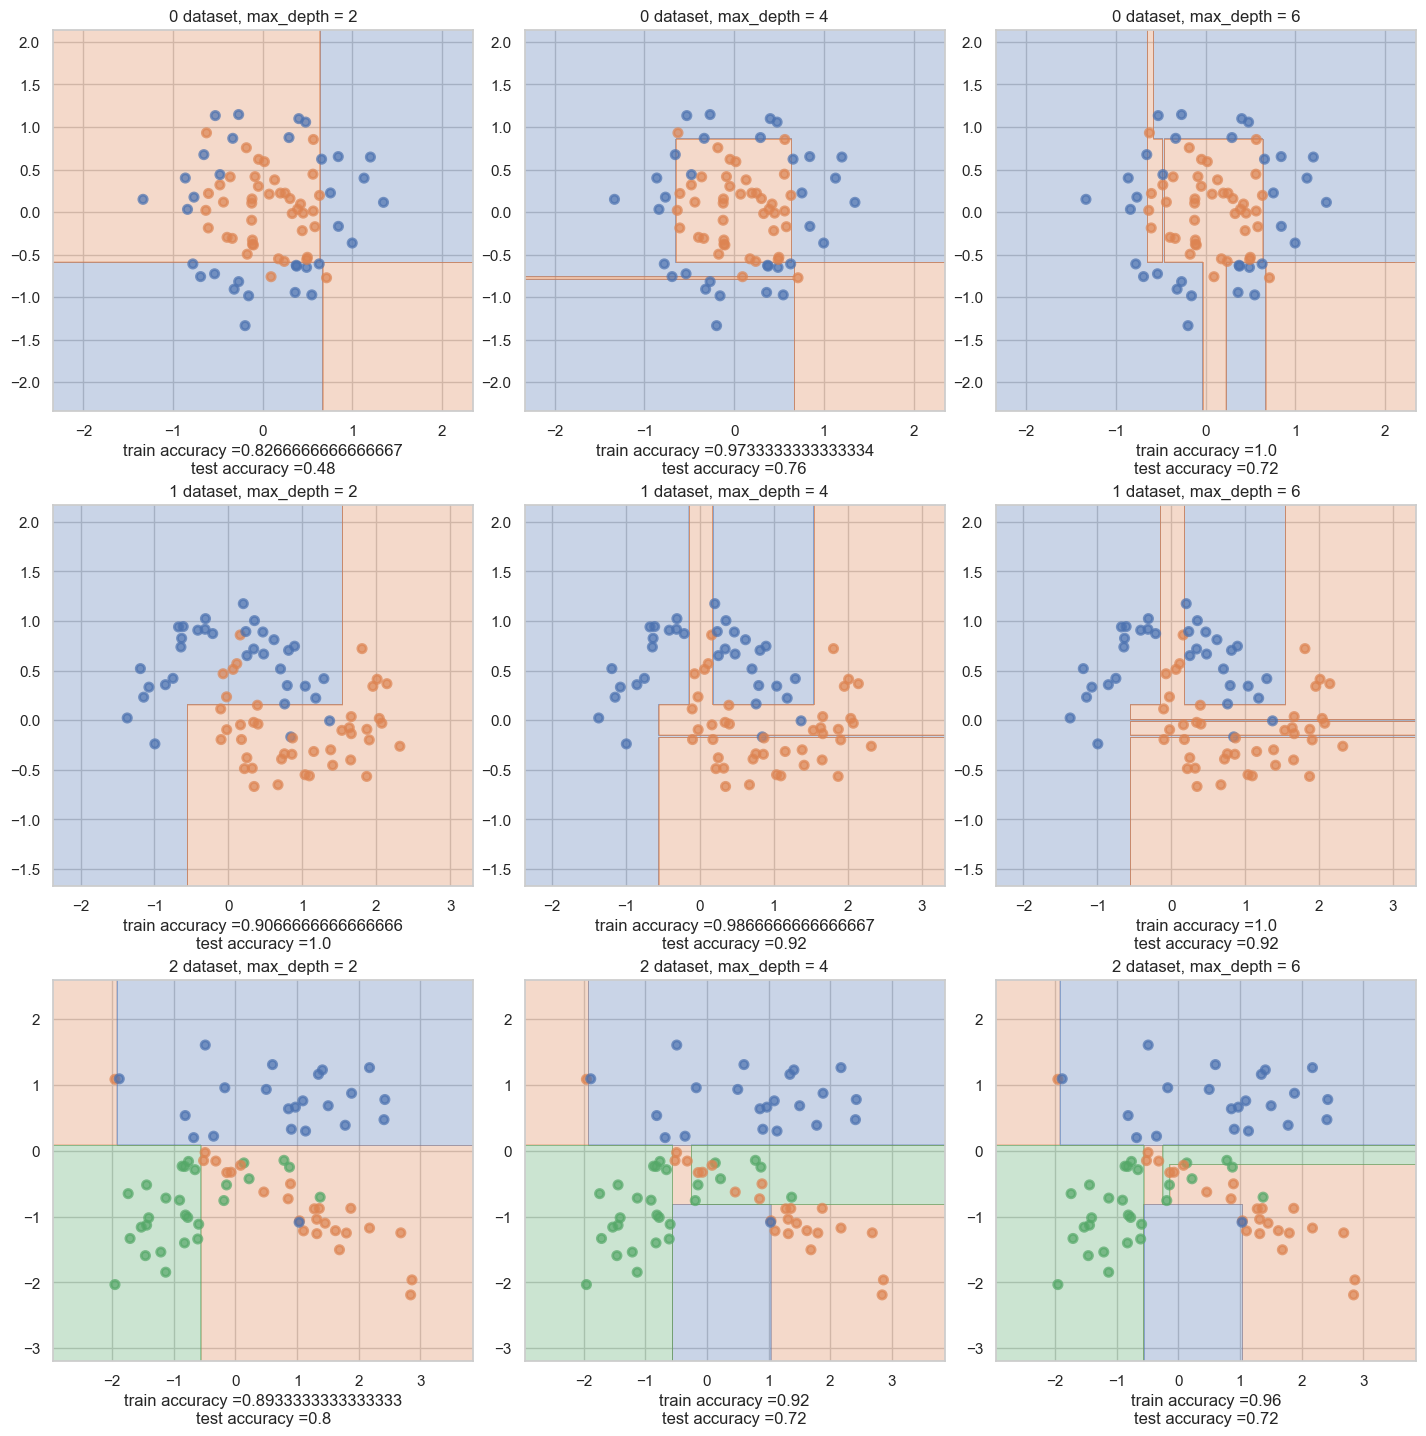

In [54]:
plt.figure(figsize = (15, 15))
spec = gridspec.GridSpec(ncols=3, nrows=3)
a = np.array([2, 4, 6])

for i, (x, y) in enumerate(datasets):
    for j in range(len(a)):
        X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.75, random_state=42)
        tree = DecisionTreeClassifier(max_depth=a[j])
        tree = tree.fit(X_train, y_train)

        plt.subplot(spec[i, j])
        plot_surface(tree, X_train, y_train)
        plt.title(str(i) + ' dataset, ' + 'max_depth = ' + str(a[j]))
        plt.xlabel('train accuracy =' + str(tree.score(X_train, y_train)) + '\n' + 'test accuracy =' + str(tree.score(X_test, y_test)))

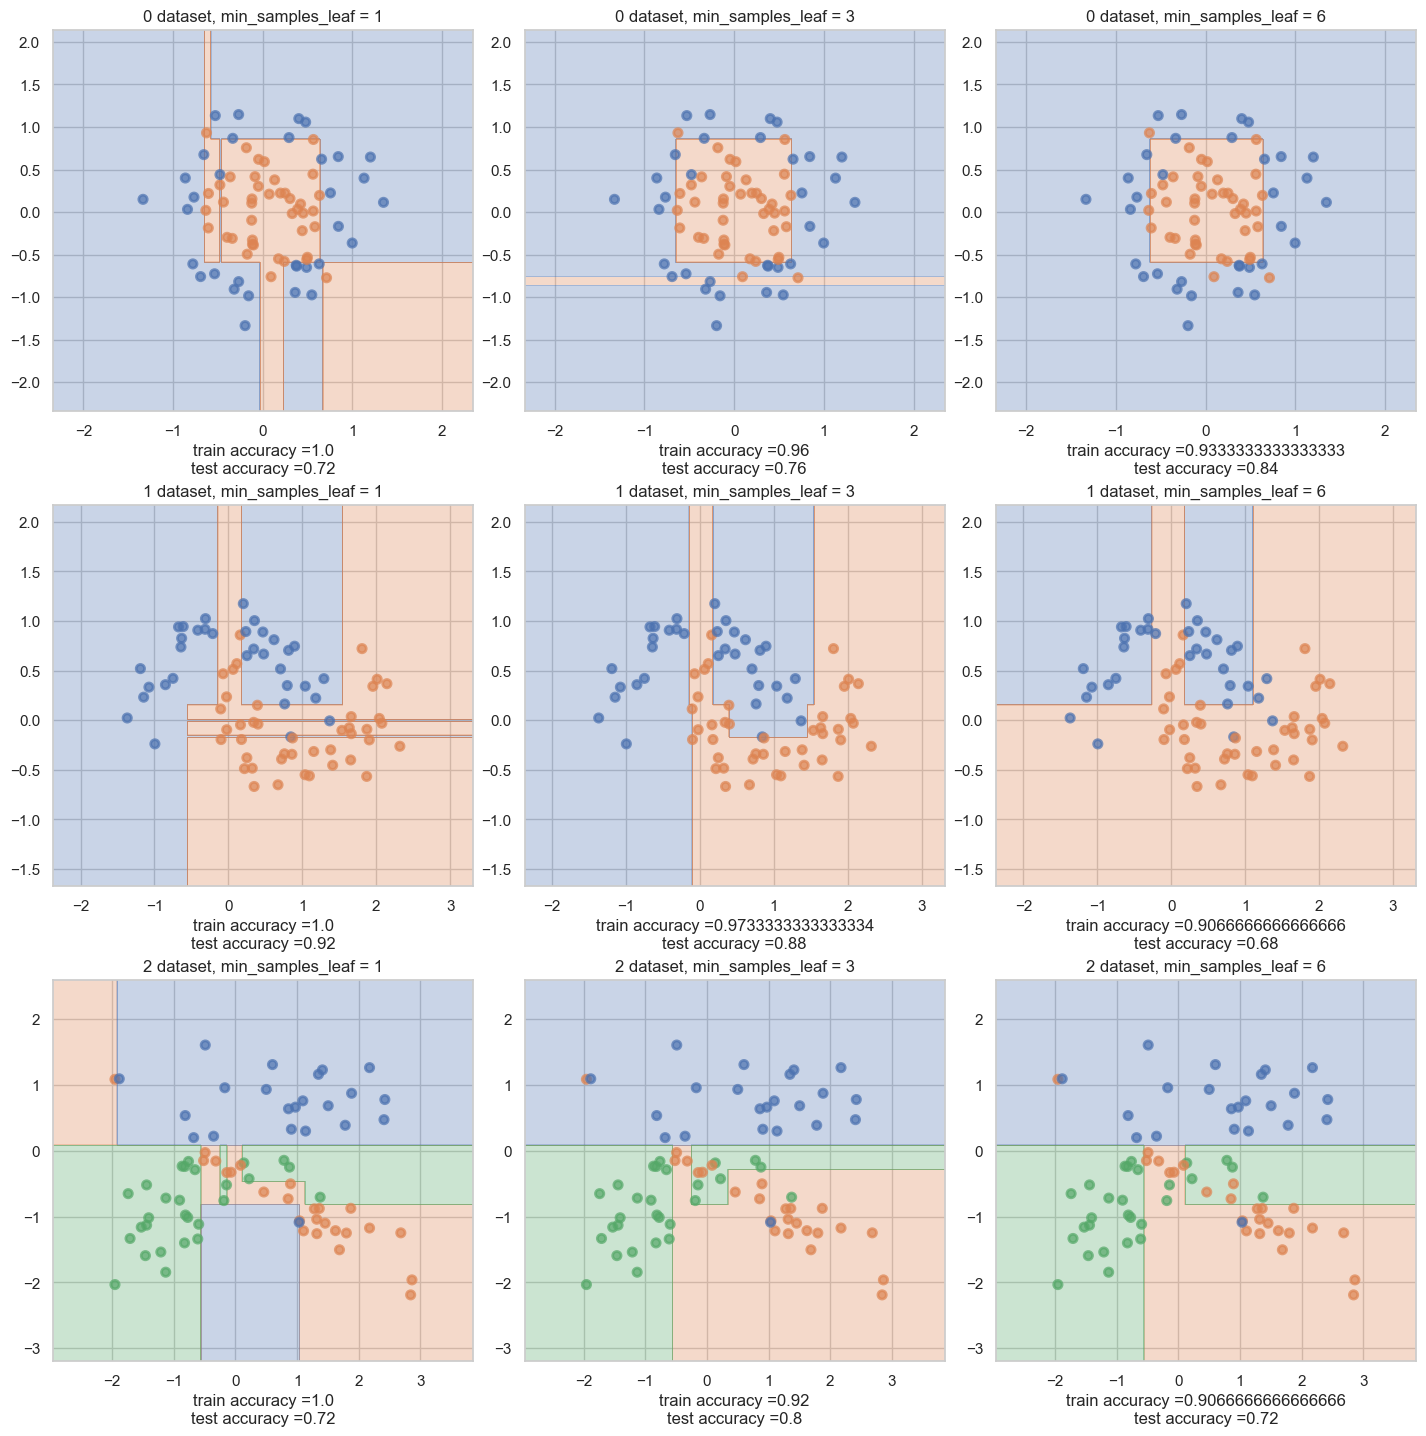

In [55]:
plt.figure(figsize = (15, 15))
spec = gridspec.GridSpec(ncols=3, nrows = 3)
a = np.array([1, 3, 6])

for i, (x, y) in enumerate(datasets):
    for j in range(len(a)):
        X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.75, random_state=42)
        tree = DecisionTreeClassifier(min_samples_leaf=a[j])
        tree = tree.fit(X_train, y_train)

        plt.subplot(spec[i, j])
        plot_surface(tree, X_train, y_train)
        plt.title(str(i) + ' dataset, ' + 'min_samples_leaf = ' + str(a[j]))
        plt.xlabel('train accuracy =' + str(tree.score(X_train, y_train)) + '\n' + 'test accuracy =' + str(tree.score(X_test, y_test)))

__Ответ:__ увеличение максимальной грубины дерева, либо уменьшение колличества объектов в листе ведет к переобучению дерева. При таких значениях параметров, значение train accuracy либо стремится к 1, либо равна ей 

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw5code.py

Под критерием Джини здесь подразумевается следующая функция:
    $$Q(R) = -\frac {|R_l|}{|R|}H(R_l) -\frac {|R_r|}{|R|}H(R_r)$$,
    $R$ — множество объектов, $R_l$ и $R_r$ — объекты, попавшие в левое и правое поддерево,
     $H(R) = 1-p_1^2-p_0^2$, $p_1$, $p_0$ — доля объектов класса 1 и 0 соответственно.

    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)

In [168]:
def find_best_split(feature_vector, target_vector):
    ind_sort = np.argsort(feature_vector)
    feature_vector_sort = np.array(feature_vector)[ind_sort]
    target_vector_sort = np.array(target_vector)[ind_sort]
    thresholds = np.unique((feature_vector_sort[:-1] + feature_vector_sort[1:]) / 2)

    R_l = (feature_vector_sort) < thresholds.reshape(-1,1)
    R_r = ~R_l
    index = R_l.any(axis=1) & R_r.any(axis=1)
    index = np.squeeze(index.reshape(1, -1))
    thresholds = thresholds[index]
    R_l = np.matrix(feature_vector_sort) < thresholds.reshape(-1,1)
    R_r = ~R_l
    
    if len(R_l) == 0 or len(R_r) == 0:
            return [], [], -np.inf, -np.inf
    
    target = np.dot(np.matrix(target_vector_sort).T, np.matrix(np.ones([1, R_l.shape[0]]))).T
    
    target_0 = np.array(target)
    target_1 = 1 - target_0
    
    target_0_l = np.multiply(R_l, target_0)
    target_1_l = np.multiply(R_l, target_1)
    
    target_0_r = np.multiply(R_r, target_0)
    target_1_r = np.multiply(R_r, target_1)
    
    p0_l = np.linalg.norm(target_0_l, ord = 1, axis = 1) / np.linalg.norm(R_l, ord = 1, axis = 1)
    p1_l = np.linalg.norm(target_1_l, ord = 1, axis = 1) / np.linalg.norm(R_l, ord = 1, axis = 1)
    
    p0_r = np.linalg.norm(target_0_r, ord = 1, axis = 1) / np.linalg.norm(R_r, ord = 1, axis = 1)
    p1_r = np.linalg.norm(target_1_r, ord = 1, axis = 1) / np.linalg.norm(R_r, ord = 1, axis = 1)
    
    H_l = 1 - np.multiply(p0_l, p0_l) - np.multiply(p1_l, p1_l) 
    H_r = 1 - np.multiply(p0_r, p0_r) - np.multiply(p1_r, p1_r) 
    
    R = R_l + R_r
    odds_l = np.linalg.norm(R_l, ord = 1, axis = 1) / np.linalg.norm(R, ord = 1, axis = 1)
    odds_r = np.linalg.norm(R_r, ord = 1, axis = 1) / np.linalg.norm(R, ord = 1, axis = 1)
    
    ginis = -(np.multiply(odds_l, H_l) + np.multiply(odds_r, H_r))
    index = np.argmax(ginis)
    
    return thresholds, ginis, thresholds[index], ginis[index]

__4. (0.5 балла)__

Загрузите таблицу [students.csv](https://drive.google.com/file/d/0B2zoFVYw1rN3a0d0Zm43TzQ4aUU/view?usp=sharing) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

In [33]:
#pip install xlrd xlwt openpyxl

In [34]:
info = pd.read_excel('students.xls', sheet_name = 0, index_col = 0)
train_data = pd.read_excel('students.xls', sheet_name = 1, index_col = 0)
test_data = pd.read_excel('students.xls', sheet_name = 2, index_col = 0)

In [35]:
train_data.head(5)

,SCG,STR,LPR,PEG,UNS
STG,,,,,
0.00,0.00,0.00,0.00,0.00,0
0.08,0.08,0.10,0.24,0.90,1
0.06,0.06,0.05,0.25,0.33,0
0.10,0.10,0.15,0.65,0.30,1
0.08,0.08,0.08,0.98,0.24,0


In [36]:
train_data.reset_index(inplace = True)

In [37]:
train_data.head(5)

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


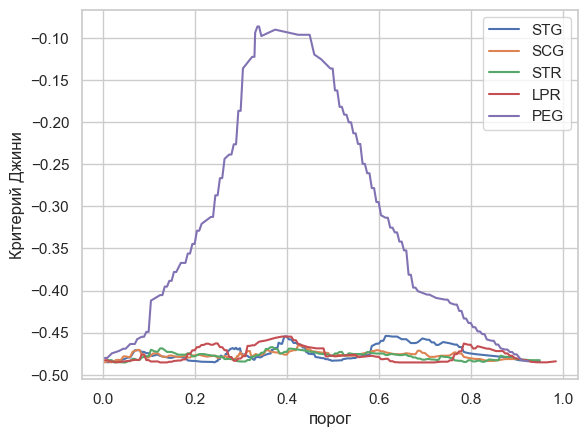

In [59]:
for i in range(5):
    thresholds, ginis, threshold_best, gini_best = find_best_split(train_data.iloc[:, i], train_data.iloc[:, 5])
    plt.plot(thresholds, ginis)
    plt.xlabel('порог')
    plt.ylabel('Критерий Джини')
plt.legend(['STG','SCG','STR','LPR','PEG'])
plt.show()

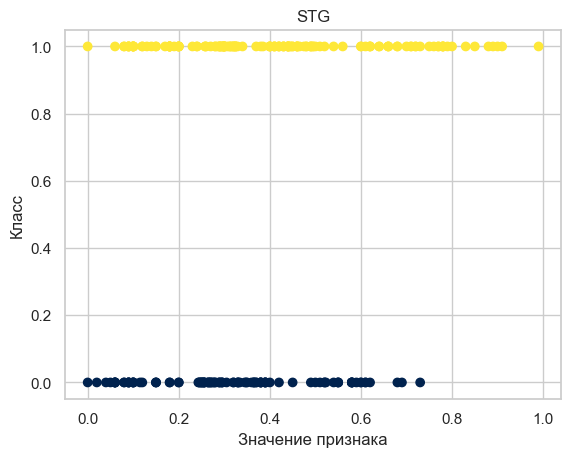

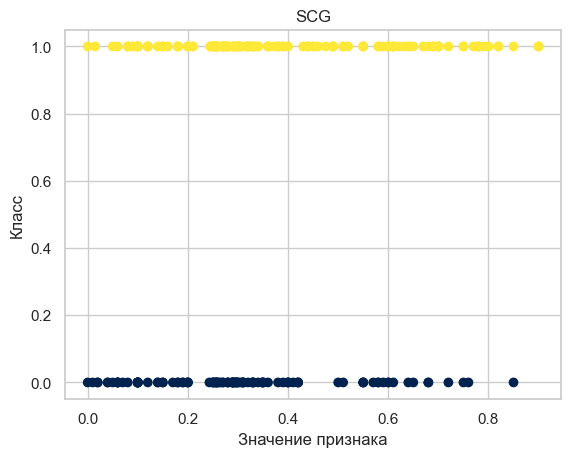

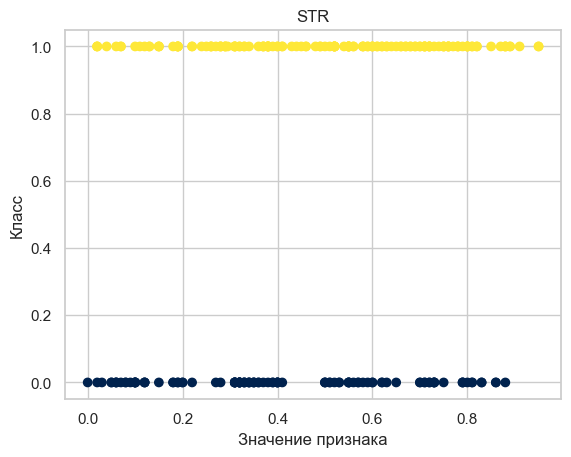

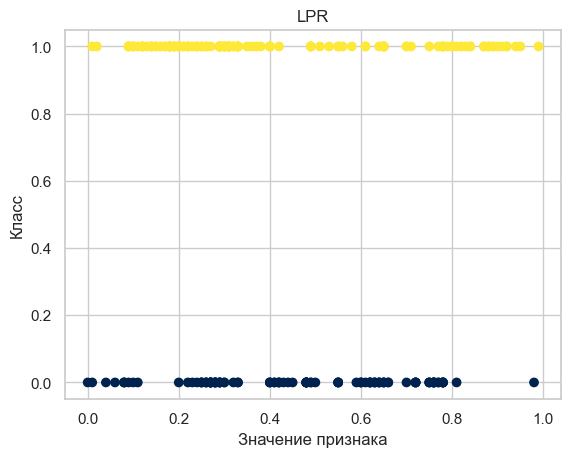

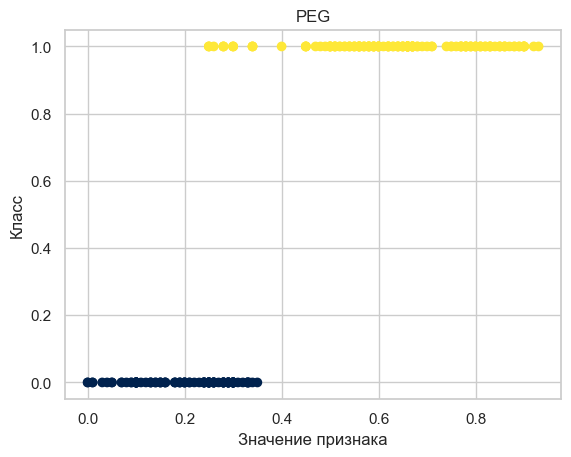

In [44]:
for i in range(5):
    plt.scatter(train_data.iloc[:, i], train_data.iloc[:, 5], c = train_data.iloc[:, 5], cmap = 'cividis')
    plt.title(train_data.iloc[:, i].name)
    plt.xlabel('Значение признака')
    plt.ylabel('Класс')
    plt.show()

__5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:** Исходя из кривых значений критерия Джинни, производить деление выборки на два поддерева нужно по признаку **PEG**. Этот результат **согласуется** с визуальной оценкой scatter-графиков, по нему видно **хорошее разделение** данных по классам. На кривой PEG явно выражена **точка максимума**. Значения на других кривых колеблются в одной небольшой окрестности, точка максимума явна не выявляется, поэтому по этим признакам деление практически невозможно.

__6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw5code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева». Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

In [186]:
class DecisionTree(BaseEstimator):
    def __init__(self, feature_types, max_depth=None, min_samples_split=None, min_samples_leaf=None):
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        self._tree = {}
        self._feature_types = feature_types
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf

    def _fit_node(self, sub_X, sub_y, node):
        if np.all(sub_y == sub_y[0]): #2
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(0, sub_X.shape[1]): #3
            feature_type = self.feature_types[feature]
            categories_map = {}

            if feature_type == "real":
                feature_vector = sub_X[:, feature]
                
            elif feature_type == "categorical":
                counts = Counter(sub_X[:, feature])
                clicks = Counter(sub_X[sub_y == 1, feature])
                ratio = {}
                for key, current_count in counts.items():
                    if key in clicks:
                        current_click = clicks[key]
                        ratio[key] = current_count / current_click
                    else:
                        current_click = 0
                        ratio[key] = 0
                
                sorted_categories = sorted(ratio.keys(),
                                           key=lambda k: ratio[k]) 
                
                categories_map = dict(zip(sorted_categories,
                                          range(len(sorted_categories))))
                
                feature_vector = np.array(list(map(lambda x: categories_map[x], sub_X[:, feature])))
            else:
                raise ValueError
            
            if len(feature_vector) == 3:
                continue
                
            _, _, threshold, gini = find_best_split(feature_vector, sub_y)
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini
                split = feature_vector < threshold

                if feature_type == "real":
                    threshold_best = threshold
                elif feature_type == "categorical":
                    threshold_best = list( map(lambda x: x[0], 
                                filter(lambda x: x[1] < threshold,categories_map.items())))
                else:
                    raise ValueError

        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self.feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
            
        elif self.feature_types[feature_best] == "categorical":
            node["categories_split"] = threshold_best
            
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"]) #1

    def _predict_node(self, x, node):
        if node["type"] == "terminal":
            return node["class"]
        else:
            feature_split = node["feature_split"]
            
            if self.feature_types[feature_split] == "real":
                threshold = node["threshold"]
                if x[feature_split] < threshold:
                    return self._predict_node(x, node['left_child'])
                else:
                    return self._predict_node(x, node['right_child'])
                
                
            elif self.feature_types[feature_split] == "categorical":
                threshold = node["categories_split"]
                if x[feature_split] in threshold:
                    return self._predict_node(x, node['left_child'])
                else:
                    return self._predict_node(x, node['right_child'])
                    
            else:
                raise ValueError

    def fit(self, X, y):
        self._fit_node(X, y, self._tree)

    def predict(self, X):
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
        return np.array(predicted)  

__7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [170]:
mushrooms = pd.read_csv('agaricus-lepiota.data', header=None)
mushrooms.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [171]:
LE = LabelEncoder()
mushrooms = mushrooms.apply(LE.fit_transform)
mushrooms.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1


In [172]:
targets_mushrooms = np.array(mushrooms.iloc[:, 0])
features_mushrooms = np.array(mushrooms.iloc[:, 1:])

X_train, X_test, y_train, y_test = train_test_split(features_mushrooms, targets_mushrooms, train_size=0.5, random_state=42)

type_ = np.array(['categorical'] * X_train.shape[1])
model = DecisionTree(type_)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
print("Train accuracy:", np.sum(y_pred_train == y_train) / np.size(y_train))
y_pred_test = model.predict(X_test)
print("Test accuracy:", np.sum(y_pred_test == y_test) / np.size(y_test))

Train accuracy: 1.0
Test accuracy: 1.0


__14. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

__15. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [173]:
tic_tac_toe = pd.read_csv('tic-tac-toe.data')
cars = pd.read_csv('car.data')
nursery = pd.read_csv('nursery.data')

In [174]:
tic_tac_toe.head()

,x,x.1,x.2,x.3,o,o.1,x.4,o.2,o.3,positive
0,x,x,x,x,o,o,o,x,o,positive
1,x,x,x,x,o,o,o,o,x,positive
2,x,x,x,x,o,o,o,b,b,positive
3,x,x,x,x,o,o,b,o,b,positive
4,x,x,x,x,o,o,b,b,o,positive


In [175]:
tic_tac_toe = tic_tac_toe.apply(LE.fit_transform)
targets_tic = np.array(tic_tac_toe.iloc[:, 9])
features_tic = np.array(tic_tac_toe.iloc[:, :9])
tic_tac_toe.head()

,x,x.1,x.2,x.3,o,o.1,x.4,o.2,o.3,positive
0,2,2,2,2,1,1,1,2,1,1
1,2,2,2,2,1,1,1,1,2,1
2,2,2,2,2,1,1,1,0,0,1
3,2,2,2,2,1,1,0,1,0,1
4,2,2,2,2,1,1,0,0,1,1


In [176]:
cars.head()

,vhigh,vhigh.1,2,2.1,small,low,unacc
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc


In [177]:
cars.loc[(cars['unacc'] == 'unacc'), 'unacc'] = 0
cars.loc[(cars['unacc'] == 'acc'), 'unacc'] = 0
cars.loc[(cars['unacc'] == 'good'), 'unacc'] = 1
cars.loc[(cars['unacc'] == 'vgood'), 'unacc'] = 1

cars = cars.apply(LE.fit_transform)
targets_cars = np.array(cars.iloc[:, 6])
features_cars = np.array(cars.iloc[:, :6])
cars.head()

,vhigh,vhigh.1,2,2.1,small,low,unacc
0,3,3,0,0,2,2,0
1,3,3,0,0,2,0,0
2,3,3,0,0,1,1,0
3,3,3,0,0,1,2,0
4,3,3,0,0,1,0,0


In [178]:
nursery.head()

,usual,proper,complete,1,convenient,convenient.1,nonprob,recommended,recommend
0,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
1,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
2,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
3,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority
4,usual,proper,complete,1,convenient,convenient,slightly_prob,not_recom,not_recom


In [179]:
nursery.loc[(nursery['recommend'] == 'not_recom'), 'recommend'] = 0
nursery.loc[(nursery['recommend'] == 'recommend'), 'recommend'] = 0
nursery.loc[(nursery['recommend'] == 'very_recom'), 'recommend'] = 1
nursery.loc[(nursery['recommend'] == 'priority'), 'recommend'] = 1
nursery.loc[(nursery['recommend'] == 'spec_prior'), 'recommend'] = 1

nursery = nursery.apply(LE.fit_transform)
targets_nursery = np.array(nursery.iloc[:, 8])
features_nursery = np.array(nursery.iloc[:, :8])
nursery.head()

,usual,proper,complete,1,convenient,convenient.1,nonprob,recommended,recommend
0,2,3,0,0,0,0,0,1,1
1,2,3,0,0,0,0,0,0,0
2,2,3,0,0,0,0,2,2,0
3,2,3,0,0,0,0,2,1,1
4,2,3,0,0,0,0,2,0,0


In [183]:
results = pd.DataFrame(index = ['musrooms', 'tic_tac_toe', 'cars', 'nursery'], 
                       columns = ['real', 'categorical', 'real + OHE', 'sklearn'])

In [184]:
results

,real,categorical,real + OHE,sklearn
musrooms,NaN,NaN,NaN,NaN
tic_tac_toe,NaN,NaN,NaN,NaN
cars,NaN,NaN,NaN,NaN
nursery,NaN,NaN,NaN,NaN


In [185]:
feature = [features_mushrooms, features_tic, features_cars, features_nursery]
target = [targets_mushrooms, targets_tic, targets_cars, targets_nursery]

ohe = OneHotEncoder(handle_unknown='ignore') 
ohe.set_params(sparse=False)

for i in range(4):
    
    types_ = ['real'] * feature[i].shape[1]
    scores = cross_val_score(DecisionTree(types_), feature[i], target[i], cv=10, scoring=make_scorer(accuracy_score))
    results['real'].iloc[i] = np.mean(scores)
    
    types_ = ['categorical'] * feature[i].shape[1]
    scores = cross_val_score(DecisionTree(types_), feature[i], target[i], cv=10, scoring=make_scorer(accuracy_score))
    results['categorical'].iloc[i] = np.mean(scores)
    
    feature[i] = ohe.fit_transform(feature[i])
    types_ = ['real'] * feature[i].shape[1]
    scores = cross_val_score(DecisionTree(types_), feature[i], target[i], cv=10, scoring=make_scorer(accuracy_score))
    results['real + OHE'].iloc[i] = np.mean(scores)
    
    scores = cross_val_score(DecisionTreeClassifier(), feature[i], target[i], cv=10, scoring=make_scorer(accuracy_score))
    results['sklearn'].iloc[i] = np.mean(scores)
    
results

,real,categorical,real + OHE,sklearn
musrooms,0.999261,1.0,0.999631,0.968265
tic_tac_toe,0.464792,0.59943,0.562982,0.818432
cars,0.944925,0.969845,0.924674,0.832787
nursery,0.999846,0.999769,0.999769,0.999846


__16. (1 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**